In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

from datafold.appfold import EDMD
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis
from datafold.pcfold import GaussianKernel, TSCDataFrame
import matplotlib.pyplot as plt

In [2]:
def solve_limit_cycle(initial_conditions, t_eval):
    def limit_cycle(t, y):
        """ODE system."""
        mu = 1
        y_dot = np.zeros(2)

        factor = mu - y[0] ** 2 - y[1] ** 2

        y_dot[0] = -y[1] + y[0] * factor
        y_dot[1] = y[0] + y[1] * factor
        return y_dot

    assert initial_conditions.ndim == 2
    assert initial_conditions.shape[1] == 2

    time_series_dfs = []

    for ic in initial_conditions:
        solution = solve_ivp(
            limit_cycle, t_span=(t_eval[0], t_eval[-1]), y0=ic, t_eval=t_eval
        )

        solution = pd.DataFrame(
            data=solution["y"].T,
            index=solution["t"],
            columns=["x1", "x2"],
        )

        time_series_dfs.append(solution)

    return TSCDataFrame.from_frame_list(time_series_dfs)

In [3]:
nr_time_steps = 30
t_eval = np.linspace(0, 0.4, 21)

initial_conditions = np.array(
    np.meshgrid(np.linspace(-2, 2, 8), np.linspace(-2, 2, 8))
).T.reshape(-1, 2)

tsc_data = solve_limit_cycle(initial_conditions, t_eval)

print(f"time delta: {tsc_data.delta_time}")
print(f"#time series: {tsc_data.n_timeseries}")
print(f"#time steps per time series: {tsc_data.n_timesteps}")
print(f"(n_samples, n_features): {tsc_data.shape}")
print(f"time interval {tsc_data.time_interval()}")
print(f"Same time values: {tsc_data.is_same_time_values()}")
print("")
print("Data snippet:")
tsc_data

time delta: 0.019999999999999993
#time series: 64
#time steps per time series: 21
(n_samples, n_features): (1344, 2)
time interval (0.0, 0.4)
Same time values: True

Data snippet:


feature        x1        x2
ID time                    
0  0.00 -2.000000 -2.000000
   0.02 -1.735789 -1.806650
   0.04 -1.547156 -1.676108
   0.06 -1.401879 -1.581086
   0.08 -1.286003 -1.510061
...           ...       ...
63 0.32  0.612206  1.218410
   0.34  0.578201  1.210363
   0.36  0.545490  1.203096
   0.38  0.513883  1.196435
   0.40  0.483307  1.190350

[1344 rows x 2 columns]

In [4]:
shift_start_transposed, shift_end_transposed = tsc_data.tsc.shift_matrices()

In [5]:
shift_start_transposed.shape, shift_end_transposed.shape

((2, 1280), (2, 1280))

In [6]:
np.linalg.matrix_rank(shift_start_transposed)

2

In [7]:
koopman_matrix = np.linalg.pinv(shift_start_transposed) @ shift_end_transposed
koopman_matrix.shape

(1280, 1280)

In [8]:
np.linalg.matrix_rank(koopman_matrix)

2

rank of Koopman matrix is 2 so all but 2 of its eigen values will be 0

In [9]:
eigvalues, eigvectors = np.linalg.eig(koopman_matrix)

In [10]:
np.linalg.norm(eigvectors[0] - eigvectors[1])

0.2496451581475623

In [11]:
eigvalues

array([ 9.71912250e-01+1.94280097e-02j,  9.71912250e-01-1.94280097e-02j,
       -3.16140110e-16+0.00000000e+00j, ...,
       -2.39606548e-34-6.00442274e-34j,  1.37312941e-34+2.00977287e-34j,
        1.37312941e-34-2.00977287e-34j])

In [12]:
eigvalues

array([ 9.71912250e-01+1.94280097e-02j,  9.71912250e-01-1.94280097e-02j,
       -3.16140110e-16+0.00000000e+00j, ...,
       -2.39606548e-34-6.00442274e-34j,  1.37312941e-34+2.00977287e-34j,
        1.37312941e-34-2.00977287e-34j])

In [13]:
eigvalues[0]

(0.9719122495784027+0.019428009692233694j)

In [14]:
np.linalg.norm(koopman_matrix@eigvectors[0] - eigvalues[0]*eigvectors[0])

0.19223507188833164

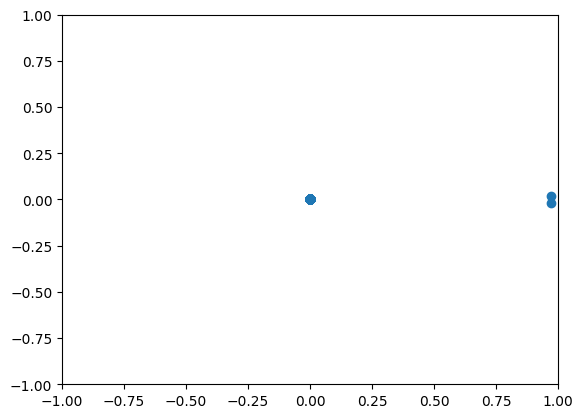

In [15]:
plt.scatter(eigvalues.real, eigvalues.imag)

# Set the axis limits
plt.xlim([-1, 1])
plt.ylim([-1, 1])

# Show the plot
plt.show()

In [16]:
eigvalues[eigvalues > 0.5]

array([0.97191225+0.01942801j, 0.97191225-0.01942801j])

In [17]:
a = np.real(eigvalues)
eigvalues[(a<0.003) & (a>0.002)]

array([], dtype=complex128)

In [18]:
np.linalg.matrix_rank(eigvectors)

1280

##### qr decomposition returns correct rank of eigen vectors

In [19]:
np.linalg.matrix_rank(np.linalg.qr(koopman_matrix)[1])

2

In [20]:
np.linalg.qr(koopman_matrix)[0]

array([[-8.04865048e-02,  1.61002251e-03,  8.37901788e-01, ...,
         8.08551539e-18,  1.13719656e-17,  1.74122769e-17],
       [-7.13081568e-02,  2.21112201e-16,  3.04397598e-01, ...,
        -2.82867605e-17, -2.93533943e-17, -3.93995960e-17],
       [-6.49092213e-02, -1.29735092e-03, -3.92601377e-02, ...,
        -9.41442454e-17, -2.89582102e-17,  5.32826736e-18],
       ...,
       [ 3.62432592e-02,  1.20002092e-02, -3.19186812e-03, ...,
         4.50489818e-16,  5.01099358e-17,  1.12593824e-16],
       [ 3.54490741e-02,  1.25282783e-02,  1.50343121e-03, ...,
        -1.01047105e-15,  4.63619321e-16,  4.24228783e-16],
       [ 3.46891053e-02,  1.30456310e-02,  9.41184442e-03, ...,
        -9.17667515e-16,  4.84739973e-17,  4.98952220e-16]])

In [21]:
eigvalues, eigvectors = np.linalg.eig(koopman_matrix)

In [22]:
np.linalg.norm(np.dot(koopman_matrix,eigvectors[1]) - eigvalues[1]*eigvectors[1])

0.18572128330102655

In [23]:
np.linalg.matrix_rank

<function numpy.linalg.matrix_rank(A, tol=None, hermitian=False)>

#### using power iteration

In [49]:
def power_iteration(A, num_iterations):
    x = np.random.rand(A.shape[1])
    for i in range(num_iterations):
        y = np.dot(A, x)
        norm = np.linalg.norm(y)
        x = y / norm
    eigenvalue = np.dot(np.dot(x, A), x.T)
    return x, eigenvalue

In [50]:
eigenvec, eigenvalue = power_iteration(koopman_matrix, num_iterations=1000)

In [51]:
eigenvalue

0.9719122495783987

In [52]:
eigenvec

array([-0.05669953, -0.04920127, -0.04384707, ...,  0.01632108,
        0.01539087,  0.01449203])



### Using DMD

In [24]:
dmd = DMDFull(is_diagonalize=False).fit(X=tsc_data, store_system_matrix=True)  # must be TSCDataFrame
dmd_values = dmd.predict(tsc_data.initial_states(), time_values=None)

In [25]:
dmd.is_diagonalize

False

In [26]:
dmd.koopman_matrix_

array([[ 0.97191225, -0.01942801],
       [ 0.01942801,  0.97191225]])

In [27]:
dmd.eigenvalues_

array([0.97191225+0.01942801j, 0.97191225-0.01942801j])

In [28]:
dmd.eigenvectors_right_

array([[0.        +0.70710678j, 0.        -0.70710678j],
       [0.70710678+0.j        , 0.70710678-0.j        ]])

In [29]:
dmd.eigenvectors_left_

In [30]:
np.linalg.norm(dmd.koopman_matrix_@dmd.eigenvectors_right_[0] - dmd.eigenvalues_[0]*dmd.eigenvectors_right_[0])

0.02747535479667293